**请注意，当前版本为可提交版本，需要注意几个地方**

**1、predict.py生成result.json时更改image_name为image_id**

**2、predict.py生成result.json时更改计算x、y的方式**

**3、提供picodet_l_640与320模型文件进行测试**


In [ ]:
!cd C:/Users/susususu/Desktop/paddle/ppq

In [5]:
import os
import json
import xml.etree.ElementTree as ET

In [ ]:


def create_pascal_voc(filename, width, height, objects, save_path):
    annotation = ET.Element("annotation")
    ET.SubElement(annotation, "folder").text = "zdy"
    ET.SubElement(annotation, "filename").text = filename
    ET.SubElement(annotation, "path").text = save_path
    source = ET.SubElement(annotation, "source")
    ET.SubElement(source, "database").text = "Unknown"
    size = ET.SubElement(annotation, "size")
    ET.SubElement(size, "width").text = str(width)
    ET.SubElement(size, "height").text = str(height)
    ET.SubElement(size, "depth").text = "3"
    ET.SubElement(annotation, "segmented").text = "0"
    for obj in objects:
        obj_elem = ET.SubElement(annotation, "object")
        ET.SubElement(obj_elem, "name").text = obj["name"]
        ET.SubElement(obj_elem, "pose").text = "Unspecified"
        ET.SubElement(obj_elem, "truncated").text = "0"
        ET.SubElement(obj_elem, "difficult").text = "0"
        bndbox = ET.SubElement(obj_elem, "bndbox")
        ET.SubElement(bndbox, "xmin").text = str(obj["xmin"])
        ET.SubElement(bndbox, "ymin").text = str(obj["ymin"])
        ET.SubElement(bndbox, "xmax").text = str(obj["xmax"])
        ET.SubElement(bndbox, "ymax").text = str(obj["ymax"])
    tree = ET.ElementTree(annotation)
    tree.write(save_path)

def convert_annotations(json_file, image_dir, output_img_dir, output_ann_dir, game_name, img_width=1920, img_height=1080, box_size=32):
    with open(json_file, 'r') as f:
        annotations = json.load(f)

    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_ann_dir, exist_ok=True)

    for frame_id, data in annotations.items():
        x, y = data["ball_position"]["x"], data["ball_position"]["y"]
        if x == -1 or y == -1:
            continue
        xmin = max(0, x - box_size // 2)
        ymin = max(0, y - box_size // 2)
        xmax = min(img_width, x + box_size // 2)
        ymax = min(img_height, y + box_size // 2)
        objects = [{"name": "pinpang", "xmin": xmin, "ymin": ymin, "xmax": xmax, "ymax": ymax}]
        original_filename = f"frame_{int(frame_id):06d}.png"
        new_filename = f"{game_name}_{original_filename}"
        xml_filename = os.path.join(output_ann_dir, f"{game_name}_frame_{int(frame_id):06d}.xml")
        img_src_path = os.path.join(image_dir, original_filename)
        img_dest_path = os.path.join(output_img_dir, new_filename)
        create_pascal_voc(new_filename, img_width, img_height, objects, xml_filename)
        if os.path.exists(img_src_path):
            os.rename(img_src_path, img_dest_path)

def process_directory(train_dir):
    output_img_dir = os.path.join(train_dir, "JPEGImages")
    output_ann_dir = os.path.join(train_dir, "Annotations")
    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_ann_dir, exist_ok=True)
    for game_folder in os.listdir(train_dir):
        game_path = os.path.join(train_dir, game_folder)
        if os.path.isdir(game_path) and game_folder.startswith("game_"):
            json_file = os.path.join(game_path, "annotations.json")
            image_dir = os.path.join(game_path, "frames")
            if os.path.exists(json_file) and os.path.exists(image_dir):
                print(f"Processing {game_folder}...")
                convert_annotations(json_file, image_dir, output_img_dir, output_ann_dir, game_folder)
    print(f"All games processed! Images and annotations saved in {output_img_dir} and {output_ann_dir}.")

train_directory = "C:/Users/susususu/Desktop/paddle/ppq/dataset/train"
process_directory(train_directory)

val_directory = "C:/Users/susususu/Desktop/paddle/ppq/dataset/val"
process_directory(val_directory)

Processing game_1...
Processing game_2...
Processing game_3...
Processing game_4...
Processing game_5...
All games processed! Images and annotations saved in C:/Users/susususu/Desktop/paddle/ppq/dataset/train\JPEGImages and C:/Users/susususu/Desktop/paddle/ppq/dataset/train\Annotations.
Processing game_1...
Processing game_2...
Processing game_3...
Processing game_4...
Processing game_5...
All games processed! Images and annotations saved in C:/Users/susususu/Desktop/paddle/ppq/dataset/val\JPEGImages and C:/Users/susususu/Desktop/paddle/ppq/dataset/val\Annotations.


In [ ]:
!cd C:/Users/susususu/Desktop/paddle/ppq
!cd C:/Users/susususu/Desktop/paddle/ppq/dataset/train
!python3 C:/Users/susususu/Desktop/paddle/ppq/work/tool/spilt_train.py

In [ ]:
!cd C:/Users/susususu/Desktop/paddle/ppq
!cd C:/Users/susususu/Desktop/paddle/ppq/dataset/val
!python C:/Users/susususu/Desktop/paddle/ppq/work/tools/spilt_val.py

In [ ]:
# 训练
%cd C:/Users/susususu/Desktop/paddle/ppq
%cd PaddleDetection
!python tools/train.py -c configs/picodet/ppq.yml \
                        --use_vdl=true \
                        --vdl_log_dir=../work/vdl_dir \
                        --eval \
                        -o save_dir=../work/model


C:\Users\susususu\Desktop\paddle\乒乓球
C:\Users\susususu\Desktop\paddle\乒乓球\PaddleDetection
^C


In [2]:
# # 评估
%cd C:/Users/susususu/Desktop/paddle/ppq
%cd PaddleDetection
!python tools/eval.py -c configs/picodet/ppq.yml \
                    -o weights=../work/model/ppq/best_model.pdparams 
                    # --classwise \

C:\Users\susususu\Desktop\paddle\ppq
C:\Users\susususu\Desktop\paddle\ppq\PaddleDetection
[04/01 19:14:16] ppdet.utils.checkpoint INFO: Skipping import of the encryption module.
[04/01 19:14:17] ppdet.utils.checkpoint INFO: Finish loading model weights: ../work/model/ppq/best_model.pdparams
[04/01 19:14:18] ppdet.engine.callbacks INFO: Eval iter: 0
[04/01 19:14:36] ppdet.metrics.metrics INFO: Accumulating evaluatation results...
[04/01 19:14:36] ppdet.metrics.metrics INFO: mAP(0.50, 11point) = 98.26%
[04/01 19:14:36] ppdet.engine.callbacks INFO: Total sample number: 434, average FPS: 22.82410958845024


W0401 19:14:16.751483 28088 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 8.9, Driver API Version: 12.3, Runtime API Version: 12.0
W0401 19:14:16.754511 28088 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.


In [ ]:
# 推理
%cd C:/Users/susususu/Desktop/paddle/ppq
%cd PaddleDetection
!python tools/infer.py -c configs/picodet/ppq.yml \
                    --infer_dir=C:/Users/susususu/Desktop/paddle/ppq/dataset/val/JPEGImages \
                    -o weights=C:/Users/susususu/Desktop/paddle/ppq/work/model/ppq/best_model.pdopt \
                    --output_dir=C:/Users/susususu/Desktop/paddle/ppq/work/img

C:\Users\susususu\Desktop\paddle\ppq
C:\Users\susususu\Desktop\paddle\ppq\PaddleDetection
[04/01 21:32:03] ppdet.utils.checkpoint INFO: Skipping import of the encryption module.
[04/01 21:32:03] ppdet.utils.checkpoint INFO: Finish loading model weights: C:/Users/susususu/Desktop/paddle/ppq/work/model/ppq/best_model.pdparams
[04/01 21:32:03] train INFO: Found 434 inference images in total.
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[04/01 21:32:28] ppdet.engine INFO: Detection bbox results save in C:/Users/susususu/Desktop/paddle/ppq/work/img\game_3_frame_061123.png
[04/01 21:32:28] ppdet.engine INFO: Detection bbox results save in C:/Users/susususu/Desktop/paddle/ppq/work/img\game_1_frame_077244.png
[04/01 21:32:28] ppdet.engine INFO: Detection bbox results save in C:/Users/susususu/Desktop/paddle/ppq/work/img\game_4_frame_045011.png
[04/01 21:32:29] ppdet.engine INFO: Detection bbox results save in C:/Users/susususu/Desktop/paddle/ppq/work/img\g

W0401 21:32:03.372293 26340 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 8.9, Driver API Version: 12.3, Runtime API Version: 12.0
W0401 21:32:03.496318 26340 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.

100%|██████████| 434/434 [00:24<00:00, 17.69it/s]


C:\Users\susususu\Desktop\paddle\ppq


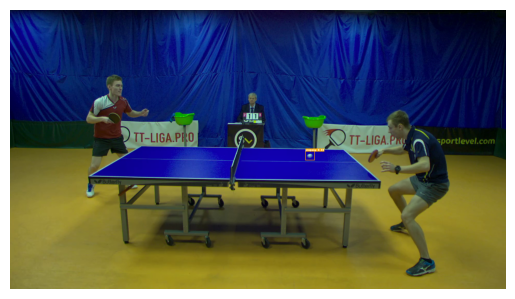

In [7]:
import matplotlib.pyplot as plt
import cv2
%cd C:/Users/susususu/Desktop/paddle/ppq
# 读取图像
image_path = "work/img/game_1_frame_012375.png"
image = cv2.imread(image_path)

# 检查图像是否成功加载
if image is None:
    print(f"Failed to load image: {image_path}")
else:
    # 转换 BGR 到 RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # 显示图像
    plt.imshow(image)
    plt.axis("off")  # 关闭坐标轴
    plt.show()


In [9]:
%cd C:/Users/susususu/Desktop/paddle/ppq
%cd PaddleDetection
!python C:/Users/susususu/Desktop/paddle/ppq/PaddleDetection/tools/export_model.py -c C:/Users/susususu/Desktop/paddle/ppq/PaddleDetection/configs/picodet/ppq.yml \
                    -o weights=C:/Users/susususu/Desktop/paddle/ppq/work/model/ppq/best_model.pdopt \
                    --output_dir=C:/Users/susususu/Desktop/paddle/ppq/work/export_model

C:\Users\susususu\Desktop\paddle\ppq
C:\Users\susususu\Desktop\paddle\ppq\PaddleDetection
[04/01 19:15:47] ppdet.utils.checkpoint INFO: Skipping import of the encryption module.
[04/01 19:15:47] ppdet.utils.checkpoint INFO: Finish loading model weights: C:/Users/susususu/Desktop/paddle/ppq/work/model/ppq/best_model.pdparams
[04/01 19:15:51] ppdet.engine INFO: Export inference config file to C:/Users/susususu/Desktop/paddle/ppq/work/export_model\ppq\infer_cfg.yml
[04/01 19:15:51] ppdet.engine INFO: Skipping import of the encryption module.
[04/01 19:15:52] ppdet.engine INFO: Export model and saved in C:/Users/susususu/Desktop/paddle/ppq/work/export_model\ppq


I0401 19:15:52.787272 38984 program_interpreter.cc:212] New Executor is Running.


In [12]:
# 修改/home/aistudio/submission/PaddleDetection/deploy/python/preprocess.py的from keypoint_preprocess import get_affine_transform为
# from .keypoint_preprocess import get_affine_transform
import os

file_path = "C:/Users/susususu/Desktop/paddle/ppq/submission/PaddleDetection/deploy/python/preprocess.py"

def modify_import_statement(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    modified_lines = [
        line.replace("from keypoint_preprocess import get_affine_transform", "from .keypoint_preprocess import get_affine_transform")
        if "from keypoint_preprocess import get_affine_transform" in line else line
        for line in lines
    ]
    with open(file_path, 'w') as f:
        f.writelines(modified_lines)
modify_import_statement(file_path)

In [15]:
import os  
# 指定要搜索的文件夹路径  
folder_path = "C:/Users/susususu/Desktop/paddle/ppq/dataset/val/JPEGImages"  
# 指定要写入的txt文件路径  
output_file = "C:/Users/susususu/Desktop/paddle/ppq/submission/output.txt"
# 获取文件夹下的所有文件和子文件夹  
files = os.listdir(folder_path)
# 打开txt文件准备写入  
with open(output_file, "w") as file:  
    # 遍历所有文件和子文件夹  
    for item in files:  
        # 如果不是文件夹，则写入文件路径到txt文件中  
        if not os.path.isdir(os.path.join(folder_path, item)):  
            file.write(os.path.join(folder_path, item) + "\n")

在测试时请务必注意result.json的格式，对齐为


[{'image_id': 'xxx.png', 'type': 'pinpang', 'x': 969.5622253417969, 'y': 536.7064819335938, 'width': 36.44512939453125, 'height': 30.5203857421875, 'segmentation': []}

In [16]:
# 可能耗时较长，40s-100s不等
%cd C:/Users/susususu/Desktop/paddle/ppq/submission
!python predict.py output.txt result.json

C:\Users\susususu\Desktop\paddle\ppq\submission
Model Arch: GFL
--transform op: Resize
--transform op: NormalizeImage
--transform op: Permute
total time: 32.0537006855011


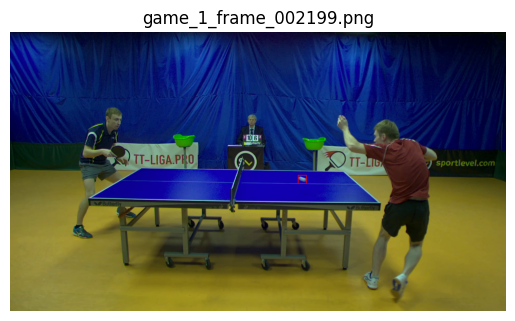

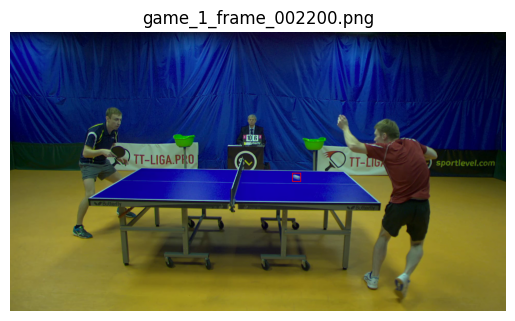

In [18]:
import json
import os
import cv2
import matplotlib.pyplot as plt

def draw_bboxes(json_file, image_folder):
    # 读取JSON文件
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    # 获取前2个检测结果
    results = data['result'][:2]
    
    for res in results:
        image_id = res['image_id']
        x, y, width, height = int(res['x']), int(res['y']), int(res['width']), int(res['height'])
        
        image_path = os.path.join(image_folder, f"{image_id}")
        
        if os.path.exists(image_path):
            # 读取图片
            image = cv2.imread(image_path)
            if image is None:
                print(f"无法读取图片: {image_path}")
                continue
            
            # 画框 (红色, 2像素厚度)
            # 将坐标转换为整数
            pt1 = (int(x - width / 2), int(y - height / 2))
            pt2 = (int(x + width / 2), int(y + height / 2))
            
            cv2.rectangle(image, pt1, pt2, (0, 0, 255), 2)
            
            # 可视化（可选）
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title(image_id)
            plt.axis('off')
            plt.show()
        else:
            print(f"图片不存在: {image_path}")

# 使用示例
draw_bboxes("C:/Users/susususu/Desktop/paddle/ppq/submission/result.json", "C:/Users/susususu/Desktop/paddle/ppq/dataset/val/JPEGImages")


In [19]:
%cd C:/Users/susususu/Desktop/paddle/ppq/submission
!zip -r submission.zip .
!echo "please download the submission.zip!"

C:\Users\susususu\Desktop\paddle\ppq\submission
  adding: model/ (164 bytes security) (stored 0%)
  adding: model/infer_cfg.yml (164 bytes security) (deflated 43%)
  adding: model/model.pdiparams (164 bytes security) (deflated 8%)
  adding: model/model.pdiparams.info (164 bytes security) (deflated 80%)
  adding: model/model.pdmodel (164 bytes security) (deflated 91%)
  adding: output.txt (164 bytes security) (deflated 95%)
  adding: PaddleDetection/ (164 bytes security) (stored 0%)
  adding: PaddleDetection/deploy/ (164 bytes security) (stored 0%)
  adding: PaddleDetection/deploy/python/ (164 bytes security) (stored 0%)
  adding: PaddleDetection/deploy/python/keypoint_preprocess.py (164 bytes security) (deflated 66%)
  adding: PaddleDetection/deploy/python/preprocess.py (164 bytes security) (deflated 77%)
  adding: PaddleDetection/deploy/python/utils.py (164 bytes security) (deflated 72%)
  adding: PaddleDetection/deploy/python/__init__.py (164 bytes security) (stored 0%)
  adding: Pad